<ipython-input-150-4cfeef9f6a52>:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()



-------PART 2--------



<ipython-input-150-4cfeef9f6a52>:263: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0
FH: 1.0 FFA: 0.0

NOISY

FH: 0.15868263473053892
FFA: 0.07303370786516854
FH: 0.14101184068891282
FFA: 0.010526315789473684
FH: 0.14558472553699284
FFA: 0.053763440860215055
FH: 0.1423913043478261
FFA: 0.009615384615384616
FH: 0.16096866096866097
FFA: 0.059006211180124224
FH: 0.13854748603351955
FFA: 0.06201550387596899
FH: 0.14208826695371368
FFA: 0.0
FH: 0.17886178861788618
FFA: 0.0
FH: 0.1411111111111111
FFA: 0.04032258064516129
FH: 0.1492027334851936
FFA: 0.00684931506849315
FH: 0.15868263473053892
FFA: 0.07303370786516854
FH: 0.14101184068891282
FFA: 0.010526315789473684
FH: 0.14558472553699284
FF

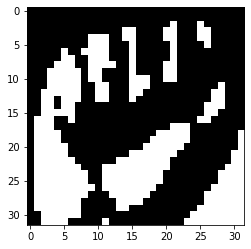

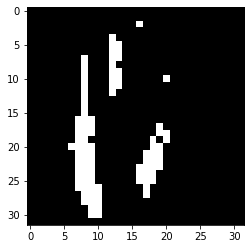

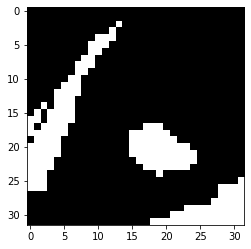

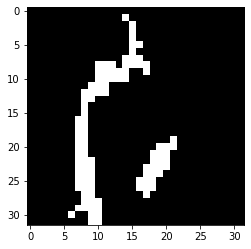

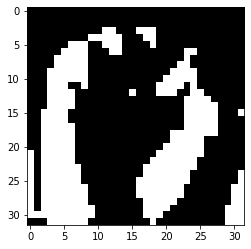

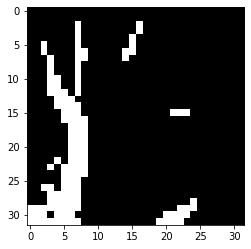

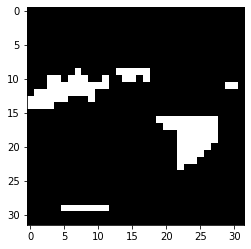

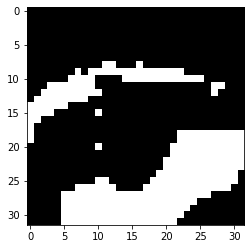

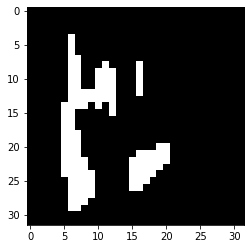

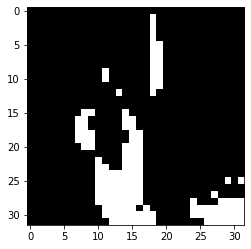

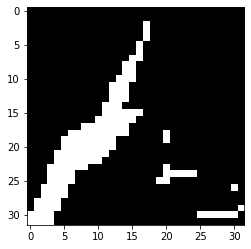

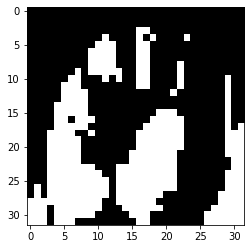

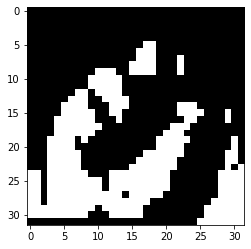

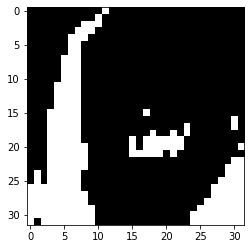

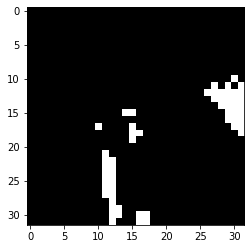

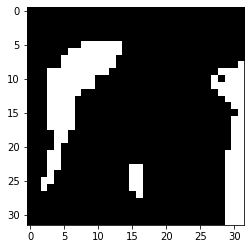

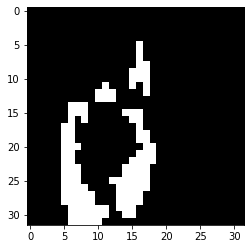

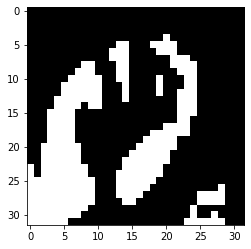

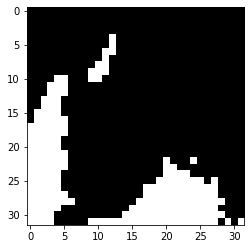

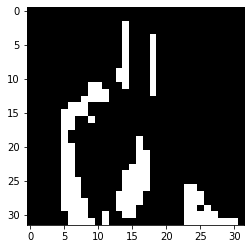

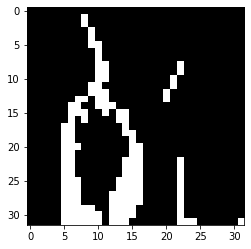

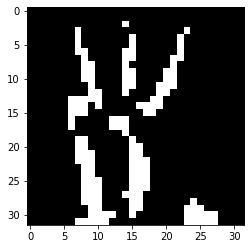

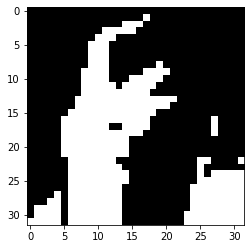

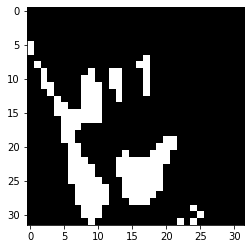

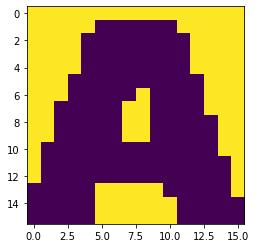

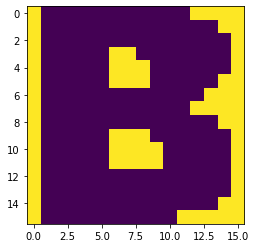

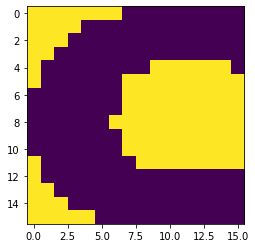

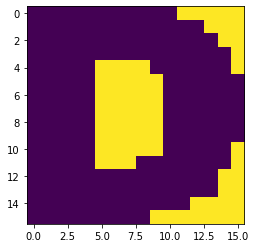

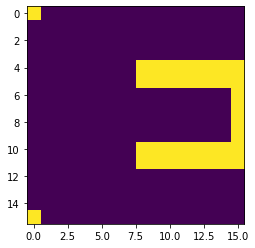

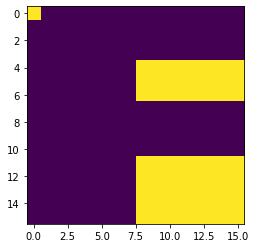

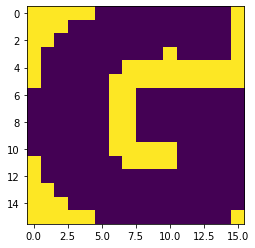

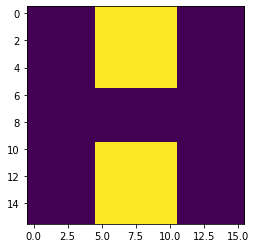

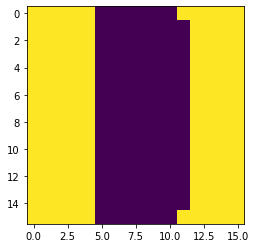

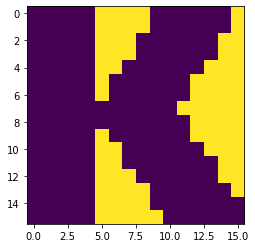

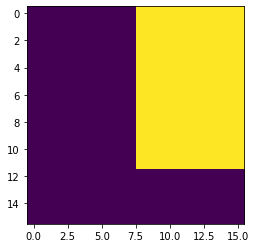

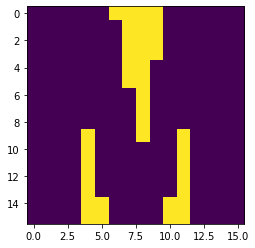

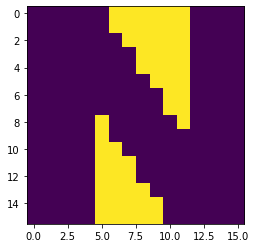

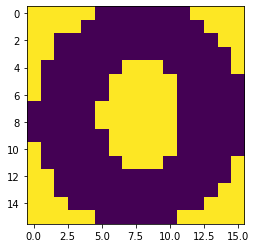

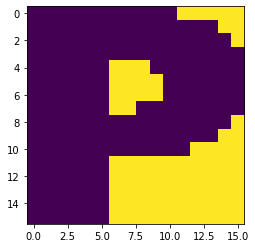

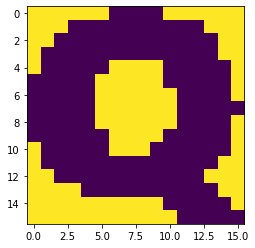

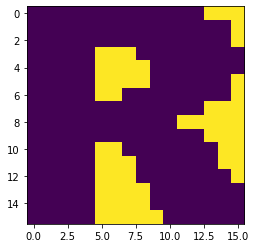

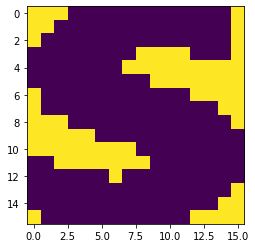

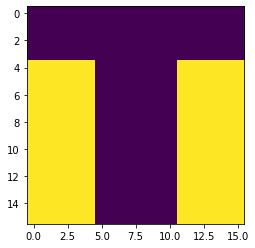

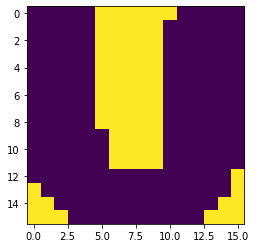

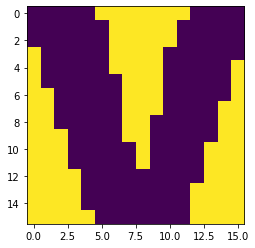

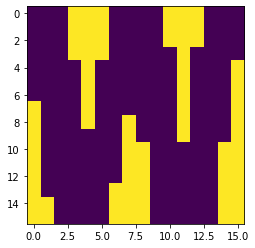

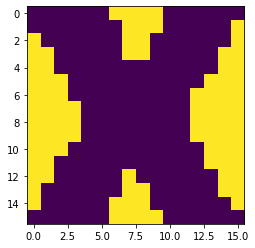

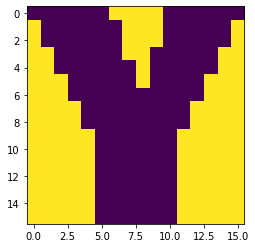

In [150]:
import numpy as np
import os
import sys
from PIL import Image
from matplotlib.pyplot import figure
import pandas
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import torch
from torch import nn
import torch.optim as optim 
from torch.utils.data import TensorDataset, DataLoader

class MLP1(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, 256),
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

class MLP2(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      #nn.Linear(4096,1024),
      #nn.Sigmoid(),
      nn.Linear(1024, 1024),
      nn.Sigmoid(),
      nn.Linear(1024,512),
      nn.Tanh(),
      nn.Linear(512,256),
      nn.LeakyReLU(),
      nn.Linear(256,128),
      nn.LeakyReLU(),
      nn.Linear(128,256),
      nn.Sigmoid(),
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

def add_noise(outputVector,noise_percent,stdev):
    '''
    Add noise to the output vector.
    '''
    mean = 0
    noise = np.random.normal(mean,stdev,outputVector.shape) * noise_percent
    return outputVector + noise

def Noisy_Testing(stdev, testRounds, inputImageVectors):
    '''
    Test the DNN with noise.
    '''
    tableObject = {}
    plotObject = {'fh': [], 'ffa': []}

    for i in range(len(stdev)):
        tableObject['std_'+ str(stdev[i]) + '_fh'] = []
        tableObject['std_'+ str(stdev[i]) + '_ffa'] = []

    for j in range(len(stdev)):   
        for k in range(testRounds) :
            corruptedVector = add_noise(inputImageVectors[k],0.1,stdev[j]) 
            testPrediction = model(torch.from_numpy(corruptedVector.astype('float32'))).detach().numpy()
            for l in range(256):
                if output[l] > 0:
                    testPrediction[l] = 1
                else:
                    testPrediction[l] = 0
            fh,ffa = calculate_performance_metrics(inputImageVectors[k],testPrediction)
            print("FH:",fh)
            print("FFA:",ffa)

def Create_Image_Set(filename, ASL):
    ImageVectors = []
    if filename!='ASL32x' and filename!='ASL64x' and ASL==False: #set1 and set2
        for i in range(10):
            path = os.path.join(os.path.dirname(os.path.abspath(sys.argv[1])),filename, str(i) +'.png')
            im = Image.open(path, 'r')
            gray = im.convert('L')
            bw = gray.point(lambda x: 0 if x<135 else 1, '1')
            ImageVectors.append(np.array(list(bw.getdata())))
        for i in range(26):
            x = i + 65
            path = os.path.join(os.path.dirname(os.path.abspath(sys.argv[1])),filename, chr(i + 65) +'.png')
            im = Image.open(path, 'r')
            gray = im.convert('L')
            bw = gray.point(lambda x: 0 if x<135 else 1, '1')
            ImageVectors.append(np.array(list(bw.getdata())))
    
    elif (filename=='ASL32x' or filename=='ASL64x') and ASL==False: #set3
        for i in range(25):
            if i!=9:
                path = os.path.join(os.path.dirname(os.path.abspath(sys.argv[1])),filename, chr(i + 65) +'.png')
                im = Image.open(path, 'r')
                gray = im.convert('L')
                bw = gray.point(lambda x: 0 if x<219 else 1, '1')
                #plt.figure()
                #plt.imshow(bw)
                ImageVectors.append(np.array(list(bw.getdata())))
    
    elif ASL==True: #set1mod
        for i in range(25):
            if i!=9:
                path = os.path.join(os.path.dirname(os.path.abspath(sys.argv[1])),filename, chr(i + 65) +'.png')
                im = Image.open(path, 'r')
                gray = im.convert('L')
                bw = gray.point(lambda x: 0 if x<135 else 1, '1')
                ImageVectors.append(np.array(list(bw.getdata())))

    return np.array(ImageVectors)

set1 = Create_Image_Set('characters1',False)
set2 = Create_Image_Set('characters2',False)
set3 = Create_Image_Set('ASL32x',False)
#set3 = Create_Image_Set('ASL64x',False)
set1mod = Create_Image_Set('characters1',True)

imageTensor = torch.Tensor(set1)
_dataSet = TensorDataset(imageTensor, imageTensor)
_dataLoader = DataLoader(_dataSet)

model = MLP1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    losses = []

    for batch_idx, (data, targets) in enumerate(_dataLoader):

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
def calculate_performance_metrics(inputVector, outputVector):
    totalBlackPixelCount = sum(x == 0 for x in inputVector)
    totalWhitePixelCount = sum(x == 1 for x in inputVector)
    wrongBlackPixelCount = 0
    rightBlackPixelCount = 0
    
    for i in range(256):
        if outputVector[i] < 0.0001:
            if  abs(outputVector[i] - inputVector[i]) < 0.0001:
                rightBlackPixelCount += 1
            else:
                wrongBlackPixelCount += 1
    fh = rightBlackPixelCount/totalBlackPixelCount
    ffa = wrongBlackPixelCount/totalWhitePixelCount
    return fh, ffa

def displayTrainingPredictions(predictionDataArray):
    '''
    Display the training predictions.
    '''
    f,axisArray = plt.subplots(len(predictionDataArray),len(predictionDataArray[0]),figsize=(10,10))
    plt.suptitle('SLP Training Set performance')
    for i in range(len(predictionDataArray)):
        for j in range(len(predictionDataArray[0])):
            axisArray[i,j].axes.xaxis.set_visible(False)
            axisArray[i,j].axes.yaxis.set_visible(False)
            if j == 0:
                axisArray[i,j].set_title('Input', fontsize=8,x =0.5,y = 0.9)
            else:
                axisArray[i,j].set_title('Epoch - '+ str(j), fontsize=8, x =0.5,y = 0.9)
            axisArray[i,j].imshow(self.getPredictedImage(predictionDataArray[i][j]))


model.eval()

print("\n------PART 1-------\n")
print("\nChecking accuracy on Training Set\n")
for i in range(36):
    output = model(torch.from_numpy(set1[i].astype('float32'))).detach().numpy()
    for j in range(256):
        if output[j] > 0:
            output[j] = 1
        else:
            output[j] = 0
    fh, ffa = calculate_performance_metrics(set1[i], output)
    print("FH:", fh, "FFA:", ffa)

print("\nChecking accuracy on Test Set\n")
for i in range(36):
    output = model(torch.from_numpy(set2[i].astype('float32'))).detach().numpy()
    for j in range(256):
        if output[j] > 0:
            output[j] = 1
        else:
            output[j] = 0
    fh, ffa = calculate_performance_metrics(set2[i], output)
    print("FH:", fh, "FFA:", ffa)
print("\nNOISY\n")
stdev = [0,0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05,0.1]
Noisy_Testing(stdev, 10, set1)

print("\n-------PART 2--------\n")
imageTensor = torch.Tensor(set3)
resultTensor = torch.Tensor(set1mod)
_dataSet = TensorDataset(imageTensor, resultTensor)
_dataLoader = DataLoader(_dataSet,batch_size=2)

model = MLP2()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    losses = []

    for batch_idx, (data, targets) in enumerate(_dataLoader):

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())
        #print("Loss at this epoch: ",loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

for i in range(24):
    output = model(torch.from_numpy(set3[i].astype('float32'))).detach().numpy()
    #print("Output: ",output," Input: ",set3[i])
    for j in range(256):
        if output[j] > 0.01:
            output[j] = 1
        else:
            output[j] = 0
    fh, ffa = calculate_performance_metrics(set1mod[i], output)
    #plt.figure()
    #plt.imshow(np.reshape(output,[16,16]))
    print("FH:", fh, "FFA:", ffa)

print("\nNOISY\n")
stdev = [0,0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05,0.1]
Noisy_Testing(stdev, 10, set3)